# Kazniva dejanja glede na kraj

## Razumevanje
V tem Razdelku bomo poizkušali **razumeti** same podatke. Poizkušali bomo podatke **urediti** na smiselen način. Podatke bomo poizkušali čim bolje **vizualizirati** in morda prepoznati določene lastnosti, ki so podatkom skupne.

Za začetek je potrebno podake **pripraviti**.

In [1]:
import pandas as pd
import glob
import warnings
import platform
from copy import copy
warnings.filterwarnings('ignore')

if (platform.system() == 'Windows'):
    l = glob.glob('data/*.csv')
    for i in range(len(l)):
        l[i] = l[i].split('\\')[-1].upper()

    # slovar poti do .csv datotek 
    csv_data = {data.split('\\')[1].split('.')[0].upper():data for data in glob.glob('data/*.csv')}
    
    # MAC IN LINUX IMATA DRUGACNE OZNAKE
else:
    l = glob.glob('data/*.csv')
    for i in range(len(l)):
        l[i] = l[i].split('/')[-1].upper()

    # slovar poti do .csv datotek 
    csv_data = {data.split('/')[1].split('.')[0].upper():data for data in glob.glob('data/*.csv')}
# just some prep for the data
dataframes = {}
for key, value in csv_data.items():
    df = pd.read_csv(csv_data[key], sep=';', encoding='cp1250', skipinitialspace = True)
    dataframes[key.upper()] = df

for df1 in dataframes.values():
    df1.columns = ['MesecStoritve' if x == 'DatumStoritve' else x for x in df]

dataframes_copy = copy(dataframes)
#make a function that merges all dataframes into one dataframe
frames = [copy(dataframes_copy['KD2009'])]
for i in range(10, 21):
    frames.append(copy(dataframes_copy['KD20'+str(i)]))

all_data = pd.concat(frames)
all_data

# tu se naredi preslikava glede iz neberljive oblike datuma v berljivo obliko
mesci = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']
mesci2 = []
leta = []

# this dataframe is the one used for the analysis
full_KD = all_data
full_KD

for i in full_KD['MesecStoritve']:
    mesec = str(i)[:-4]
    leto = str(i)[-4:]

    leta.append(leto)
    mesci2.append(mesci[int(mesec) - 1])


full_KD.rename(columns={'MesecStoritve': 'CasovnaOznaka'}, inplace=True)
full_KD['MesecStoritve'] = mesci2
full_KD['LetoStoritve'] = leta

full_KD['LetoStoritve'] = full_KD['LetoStoritve'].astype(int)

Ker bi za boljso analizo potrebovali se nekaj podatkov lahko podatke nalozimo iz interneta. Sledi koda za scrappanje podatkov iz wikipedije.

In [6]:
from selenium import webdriver
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from copy import copy

page = requests.get('https://sl.wikipedia.org/wiki/Seznam_občin_v_Sloveniji')
soup = BeautifulSoup(page.content, 'html.parser')
table = soup.find('table', attrs={'class':'wikitable sortable'})
table_body = table.find('tbody')
rows = table_body.find_all('tr')
slovar = {}
for row in rows:
    cols = row.find_all('td')
    cols = [ele.text.strip() for ele in cols]
    if cols:
        obcina = cols[0].upper()
        # povrsina (km2), prebivalci (stevilo), prebivalci na km2 (p/km2)
        povrsina = cols[1]
        povrsina = povrsina.replace(',', '.')
        prebilci = cols[2]
        prebilci_na_km2 = cols[3]
        prebilci_na_km2 = prebilci_na_km2.replace(',', '.')
        slovar[obcina] = [povrsina, prebilci, prebilci_na_km2]
        # [0] = povrsina, [1] = prebilci, [2] = prebilci na km2

## Vizualizacija
Je opravljena v seminar.ipynb

In [46]:
import geopandas as gpd
mesci = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']
path1_frames = "./animation/animation1/frames/"
slovenia = gpd.read_file('slovenija_map/obcine/obc.shp', encoding='cp1250')
slovenia['name_2'] = slovenia['name_2'].str.upper()

def kd_za_leto_in_mesec(leto, mesec):
    kd_mesec = full_KD[full_KD['MesecStoritve'] == mesec]
    kd_skupaj = kd_mesec[kd_mesec['LetoStoritve'] == leto]
    obcine = dict(kd_skupaj.UpravnaEnotaStoritve.value_counts())
    obcine_popravljene = {}
    odstrani = ['NEZNANA OBČ', 'NEZNANA UE', 'NI PODATKA']
    for o in odstrani:
        if o in obcine.keys():
            obcine.pop(o)
    for key, value in obcine.items():
        crke = ['Č', 'Š', 'Ž']
        k = key
        for i in 'ČŠŽ':
            k = k.replace(i, '?')
        obcine_popravljene[k] = value

    obcine_popravljene['LJUBLJANA'] = obcine_popravljene['LJUBLJANA']

    slovenia = gpd.read_file('slovenija_map/obcine/obc.shp', encoding='cp1250')
    slovenia['name_2'] = slovenia['name_2'].str.upper()

    list_of_all = list(slovenia.name_2)
    list_stevio = []

    for i in list_of_all:
        if i in obcine_popravljene.keys():
            list_stevio.append(obcine_popravljene[i])
        else:
            list_stevio.append(0)

    slovenia['stevilo'] = list_stevio
    fig, ax = plt.subplots(1, figsize=(20, 20))
    plt.axis('off')
    plt.title('Pogostost kaznivih dejanj v Sloveniji po občinah', fontsize=20)
    slovenia.plot(column='stevilo', cmap='RdYlGn', ax=ax, edgecolor='.2')
    bar_info = plt.cm.ScalarMappable(cmap='RdYlGn', norm=plt.Normalize(vmin=0, vmax=max(obcine.values())))
    bar_info._A = []
    cbar = fig.colorbar(bar_info, shrink=0.55)
    cbar.set_label('Število kaznivih dejanj leta' + str(leto) + str(mesec), fontsize=15, rotation=270, labelpad=40)
    plt.savefig(path1_frames+'frame'+str(leto)+str(mesec))

KeyboardInterrupt: 

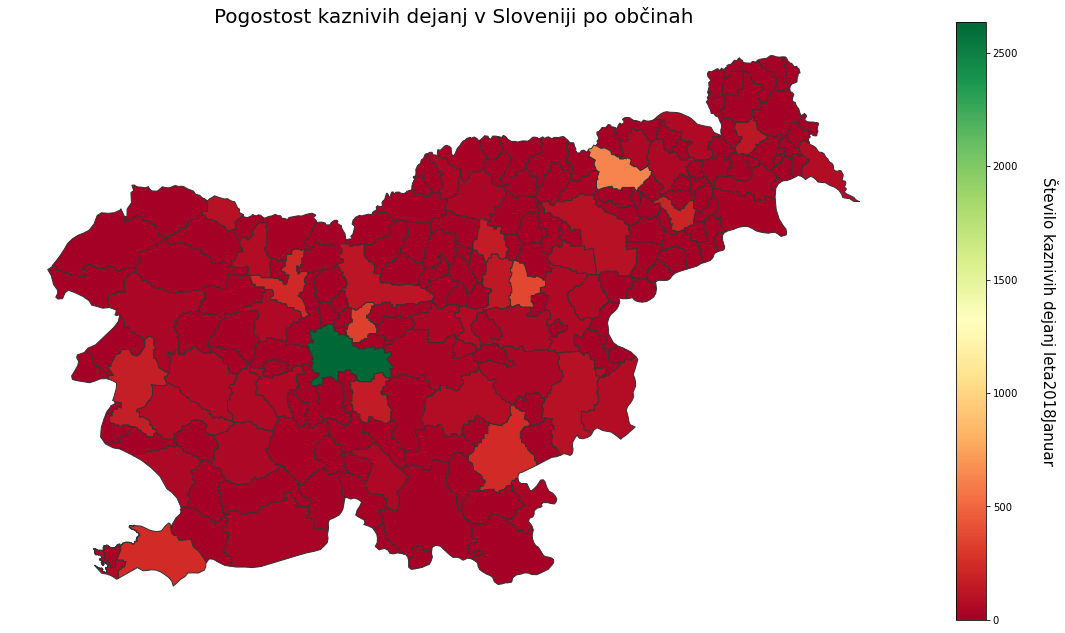

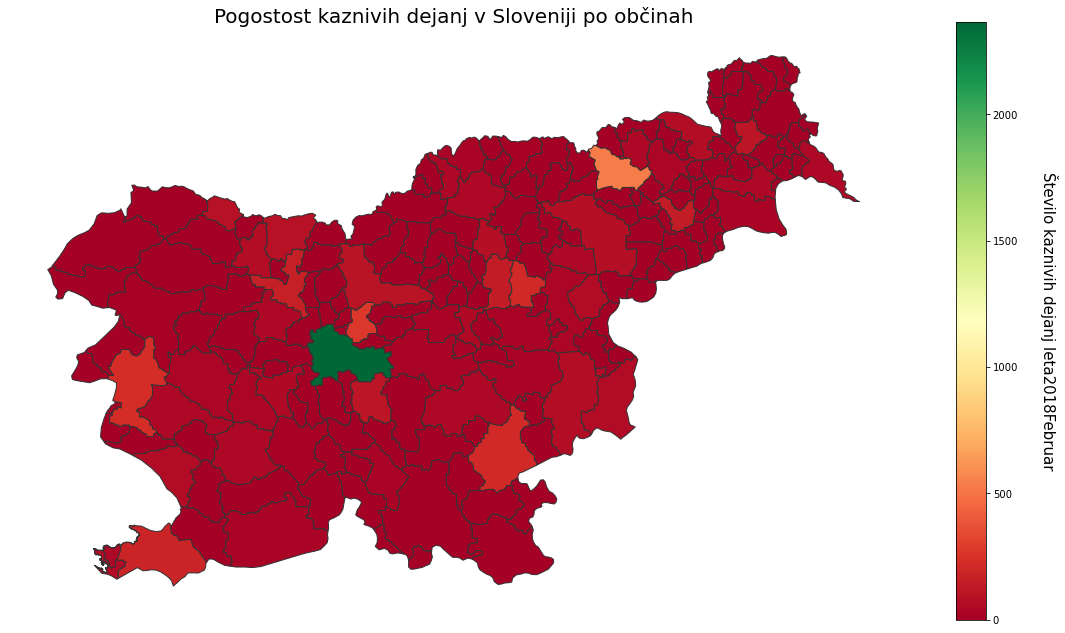

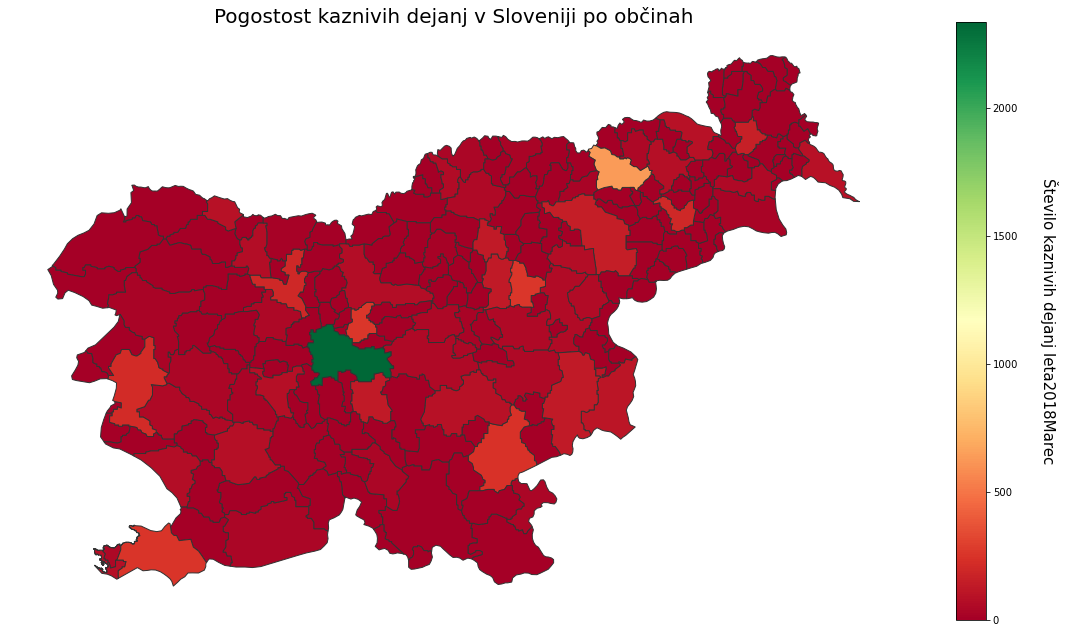

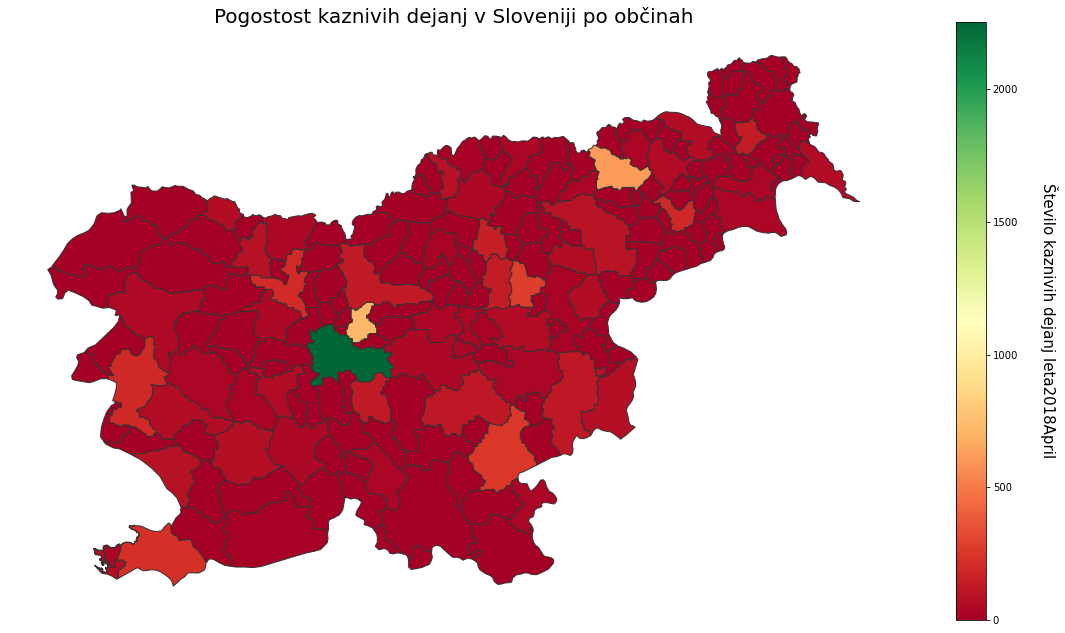

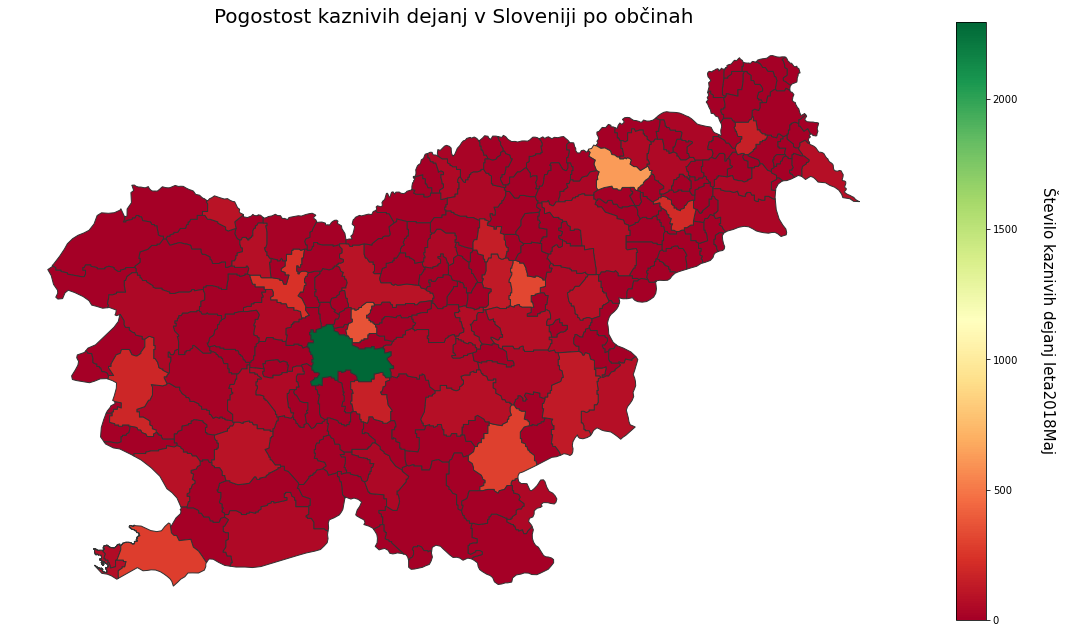

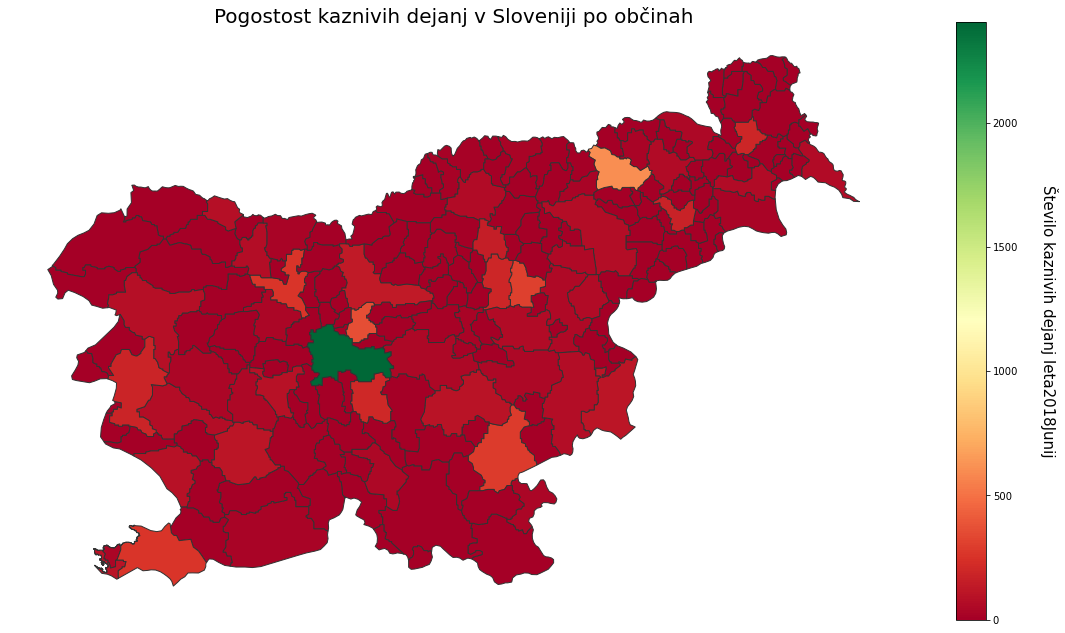

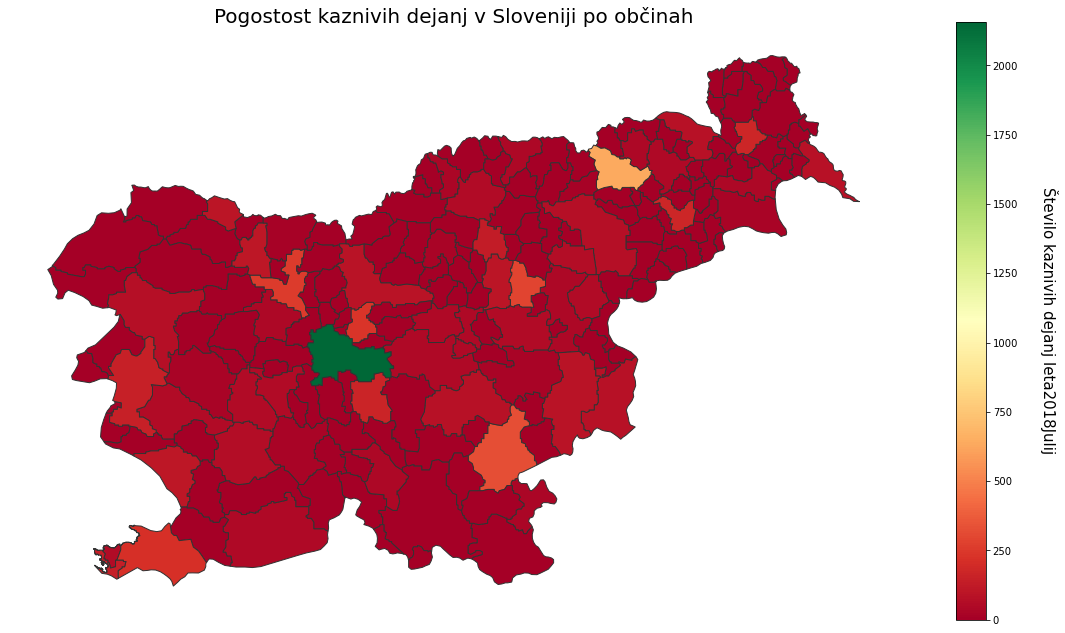

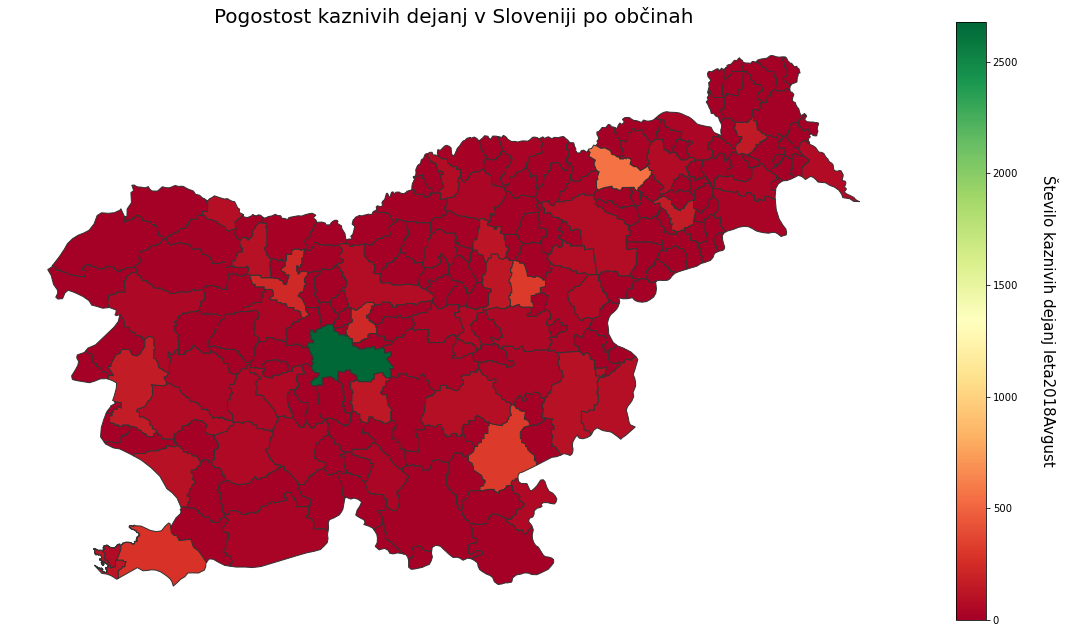

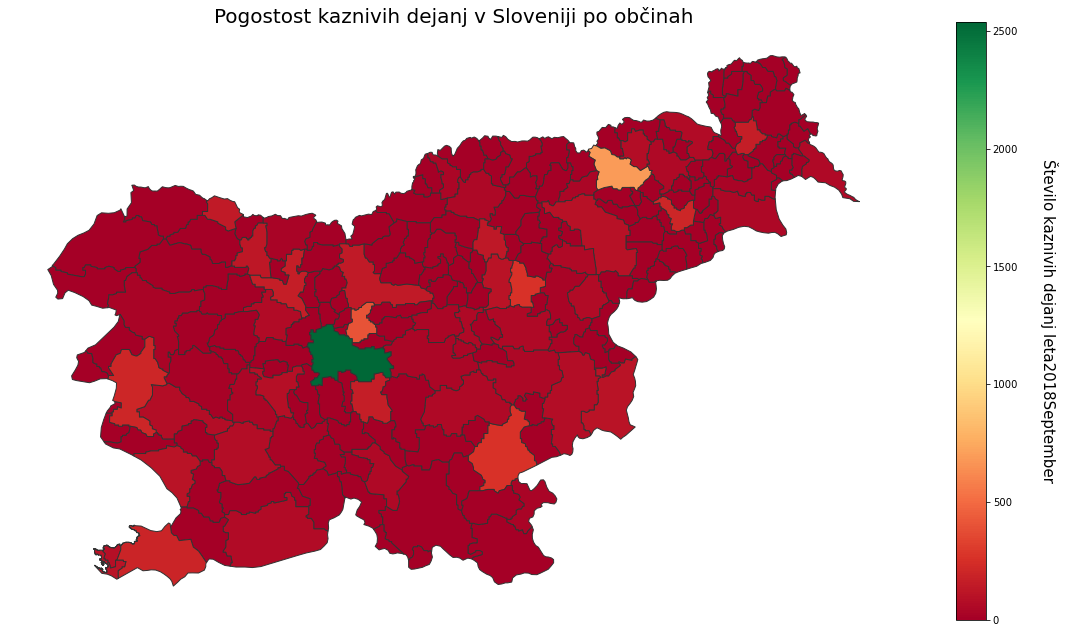

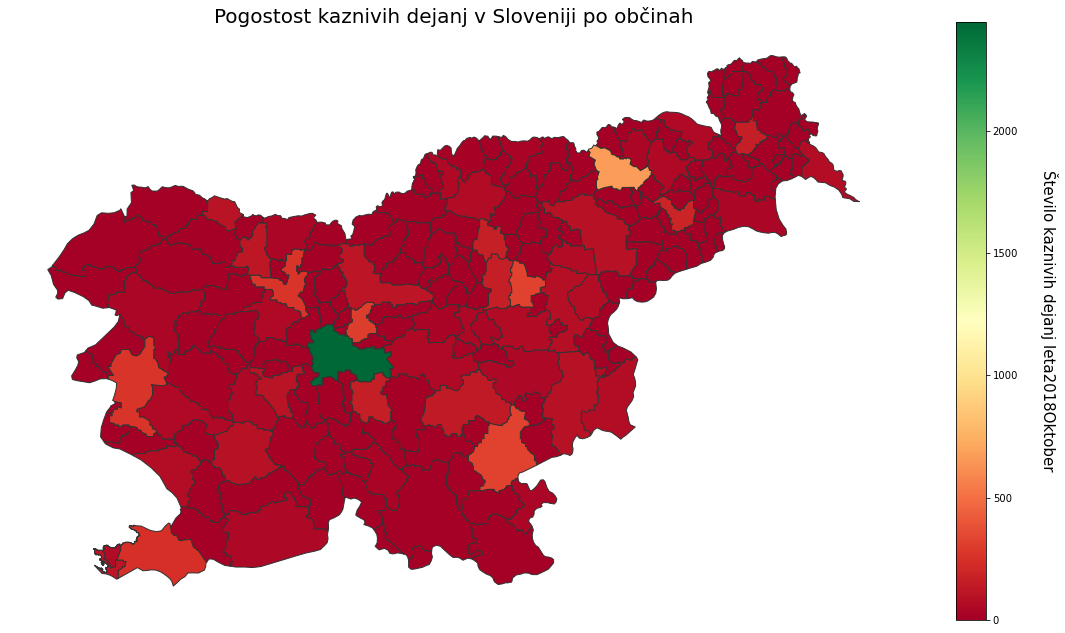

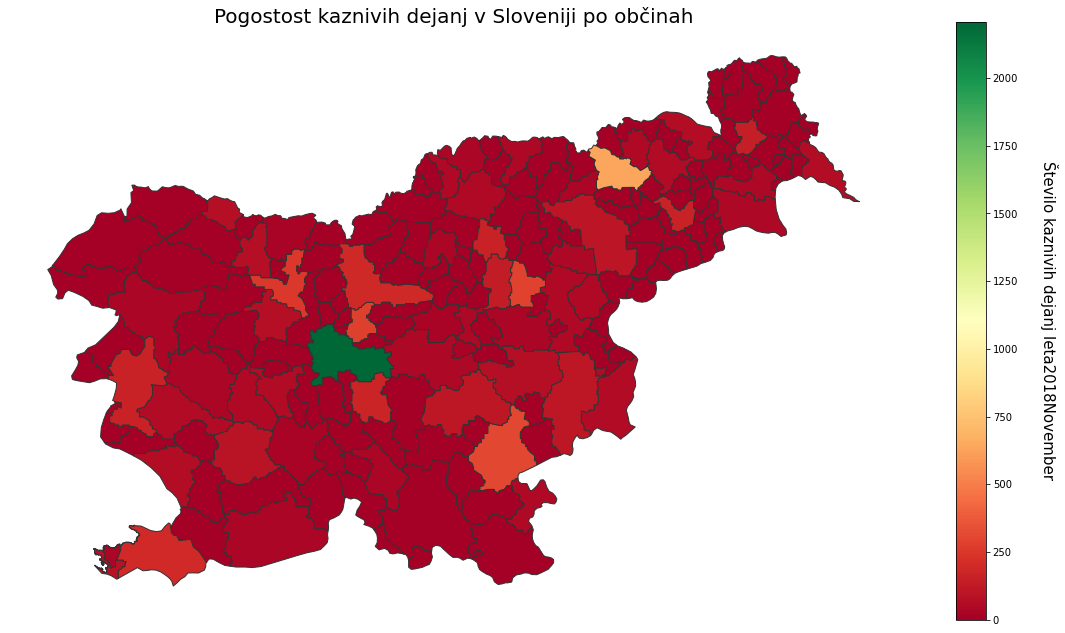

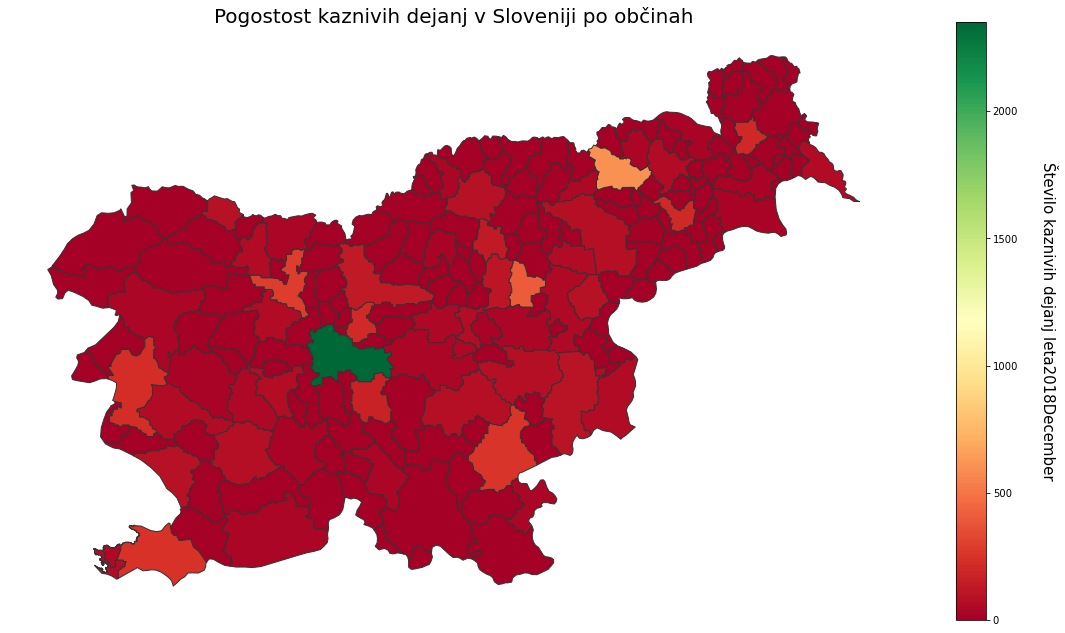

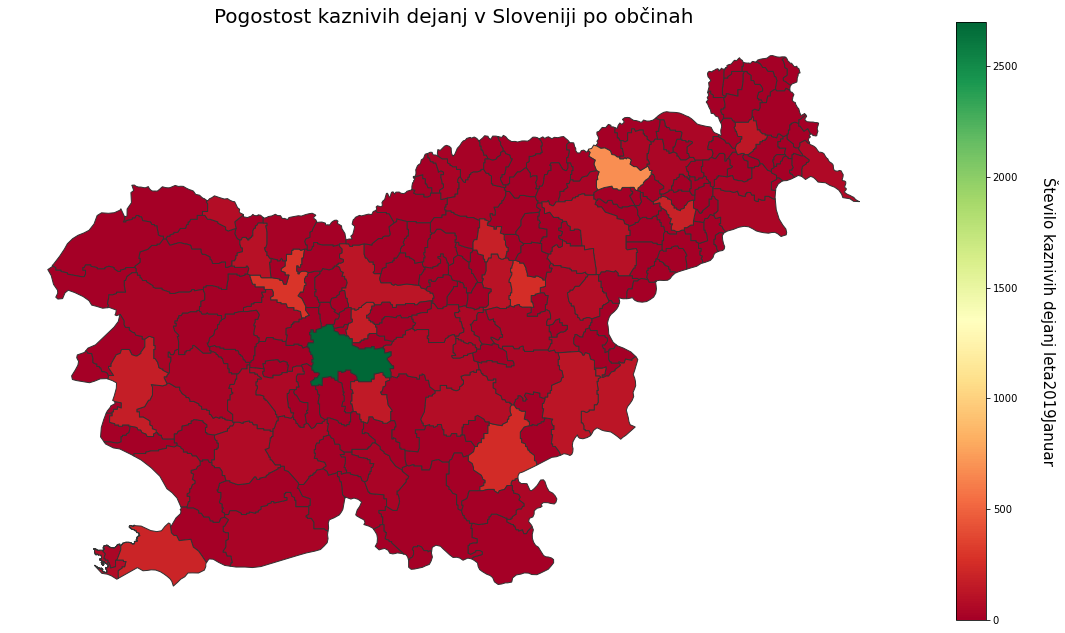

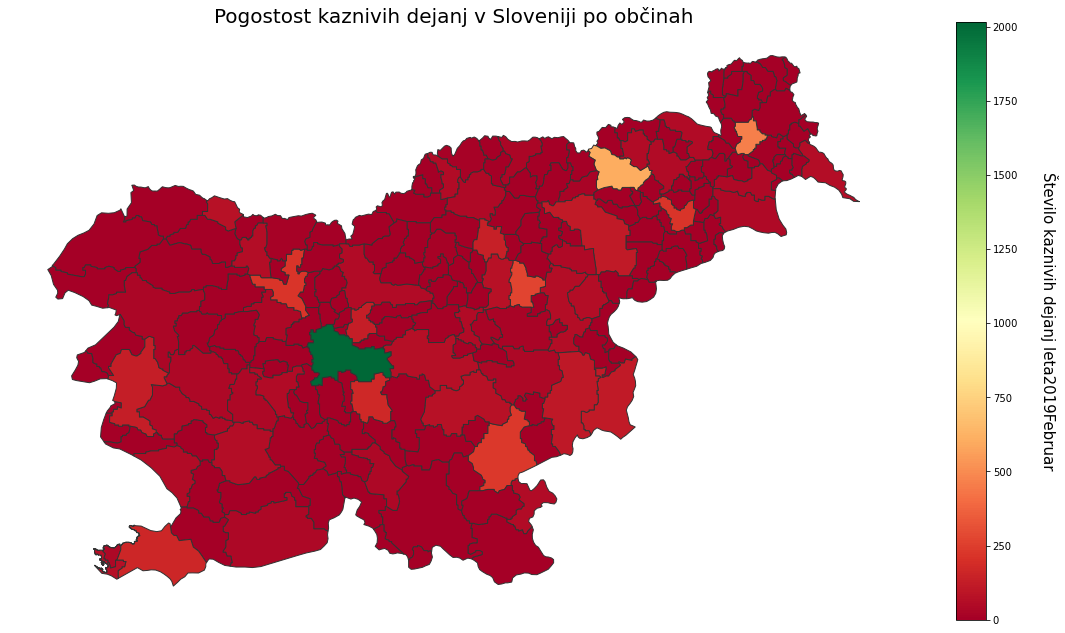

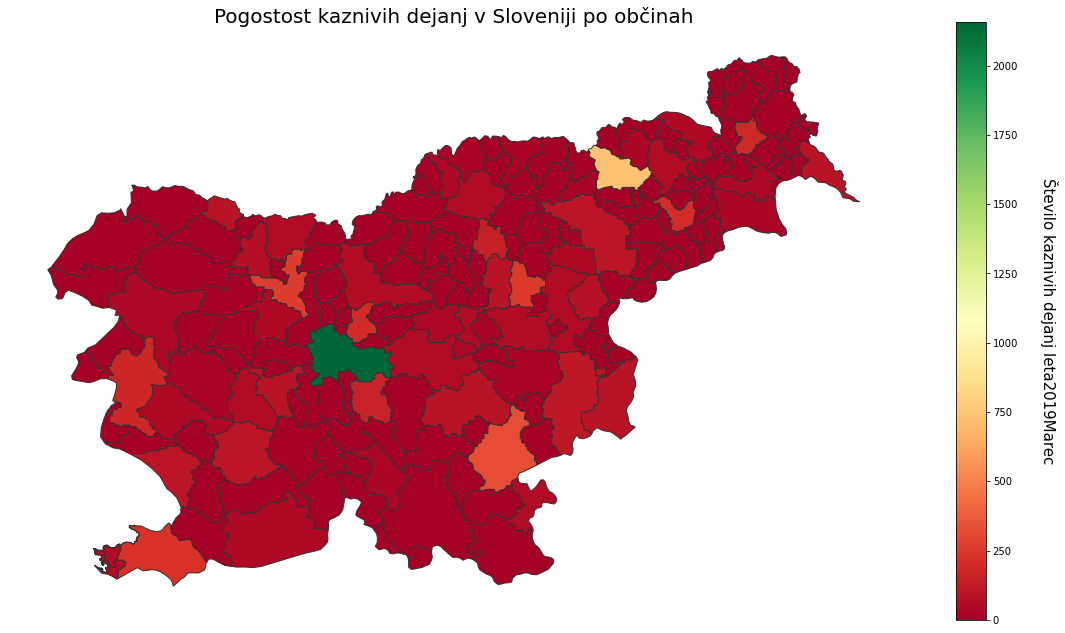

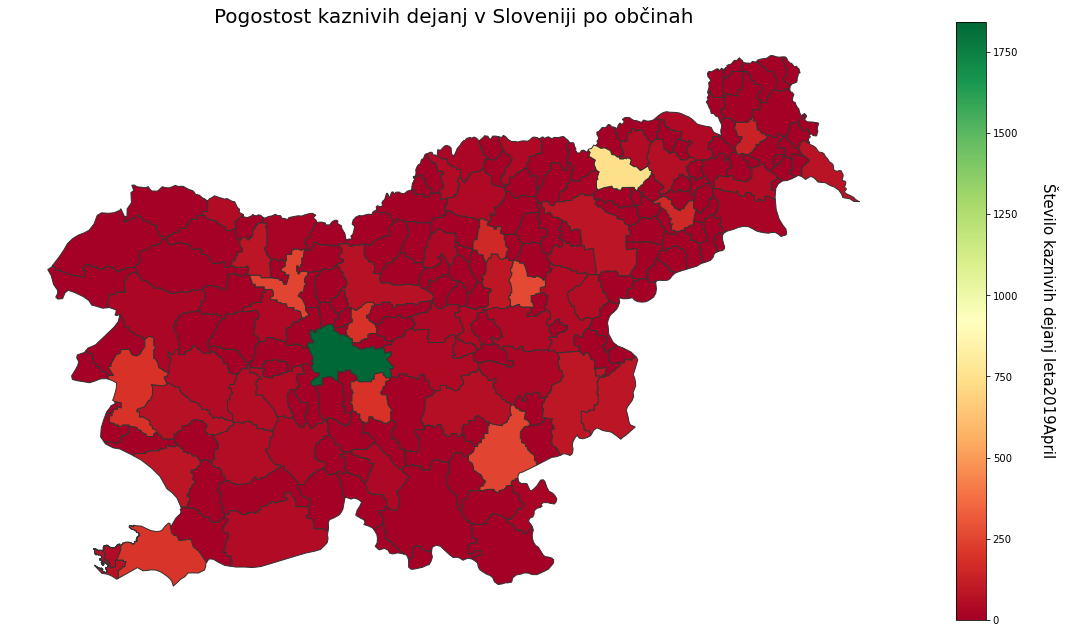

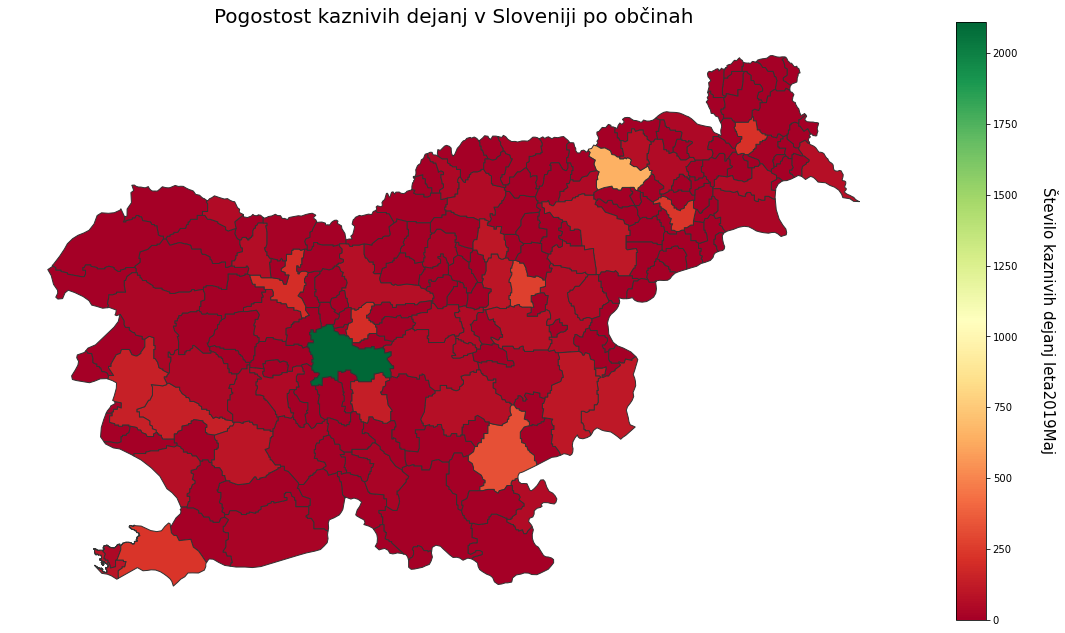

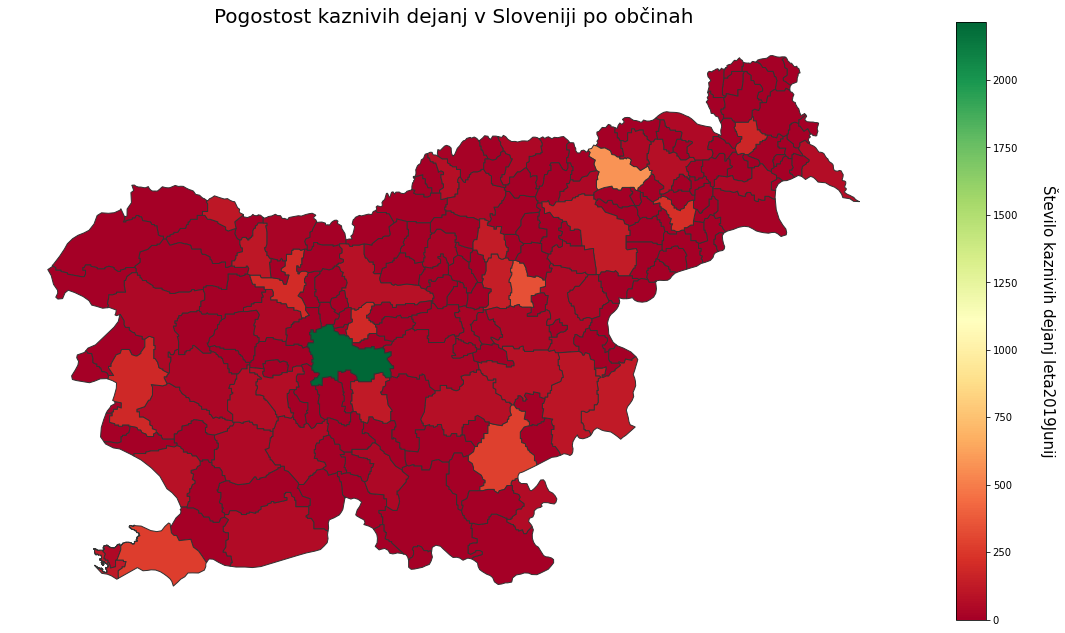

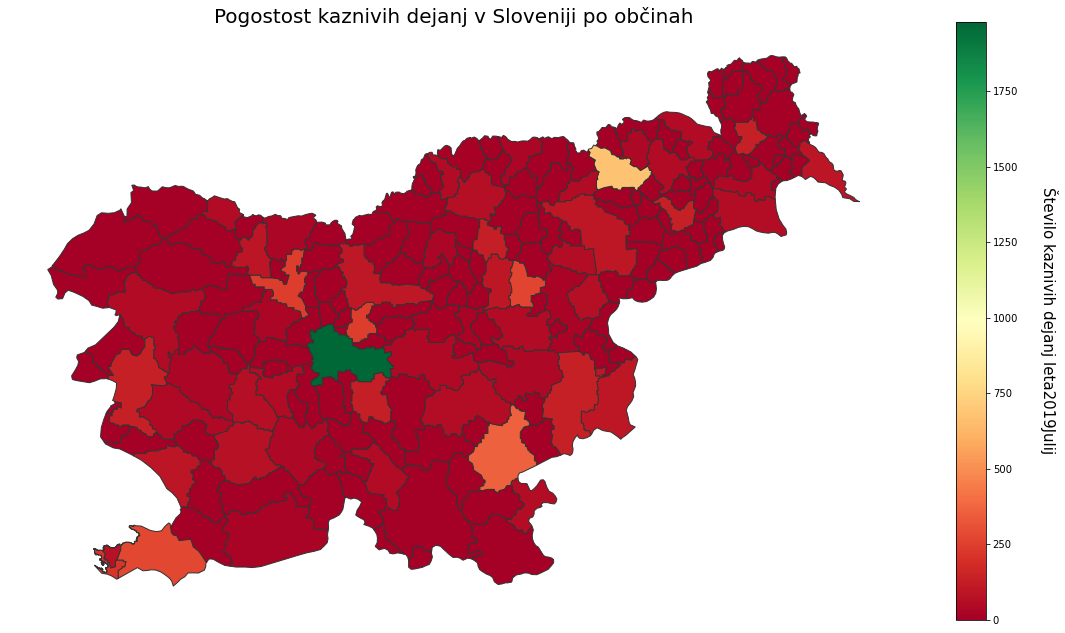

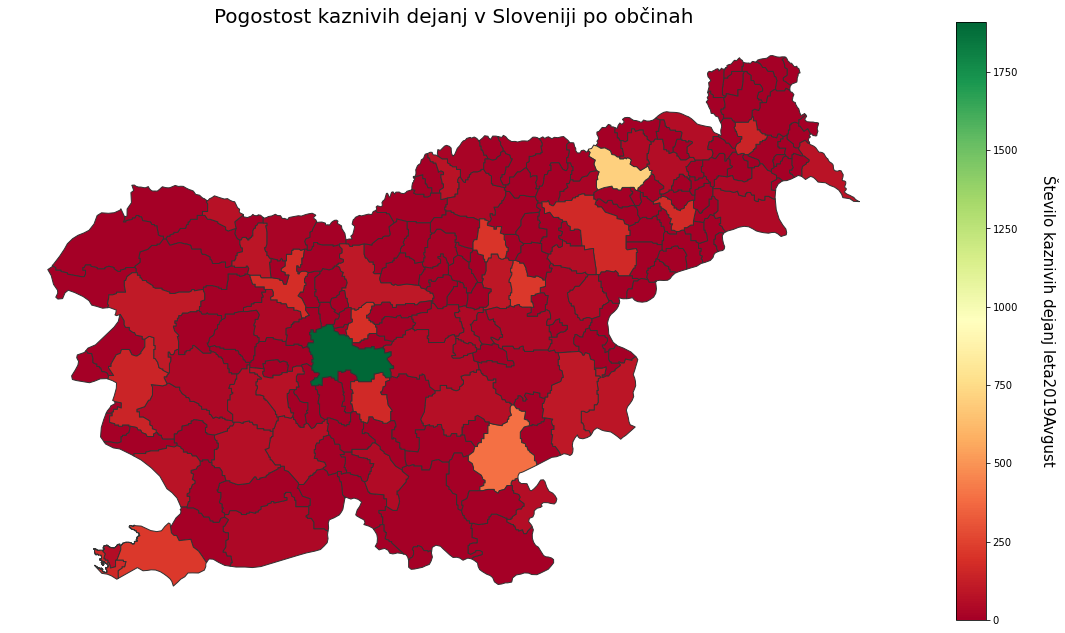

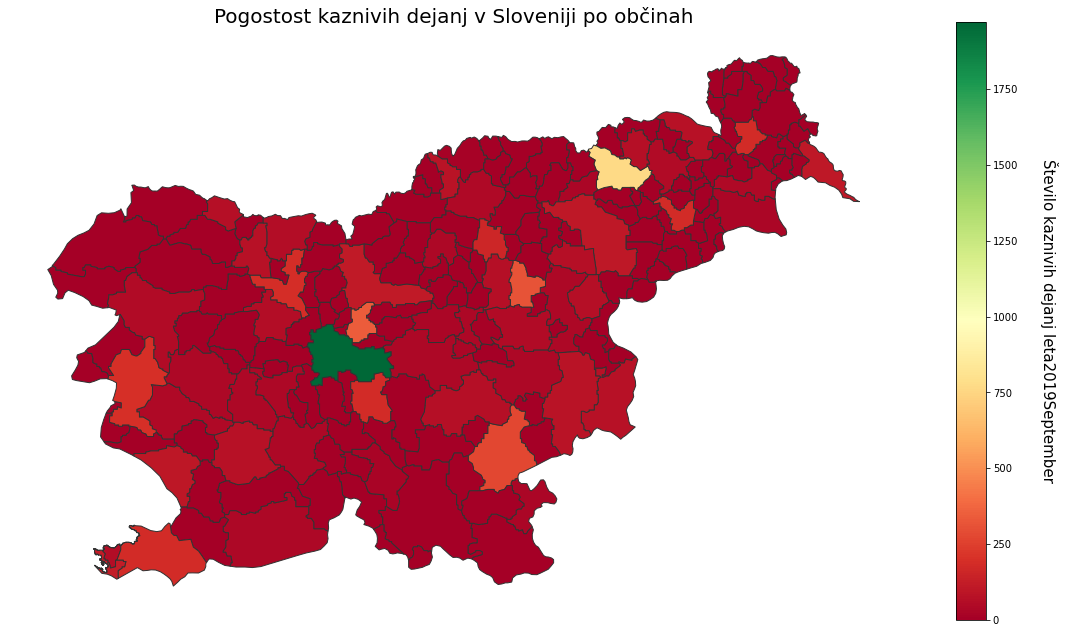

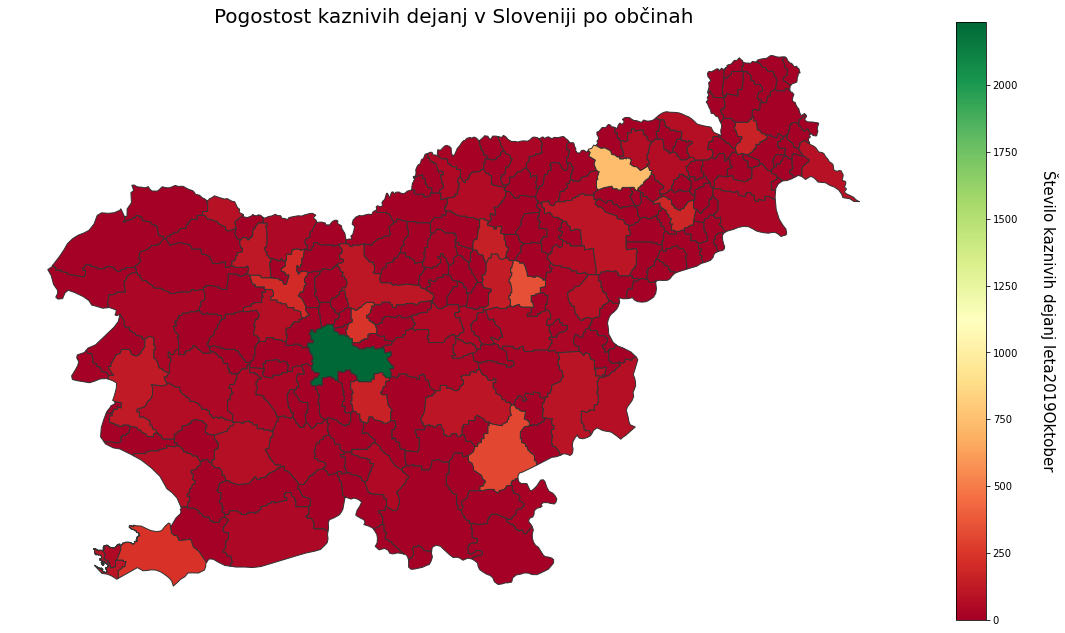

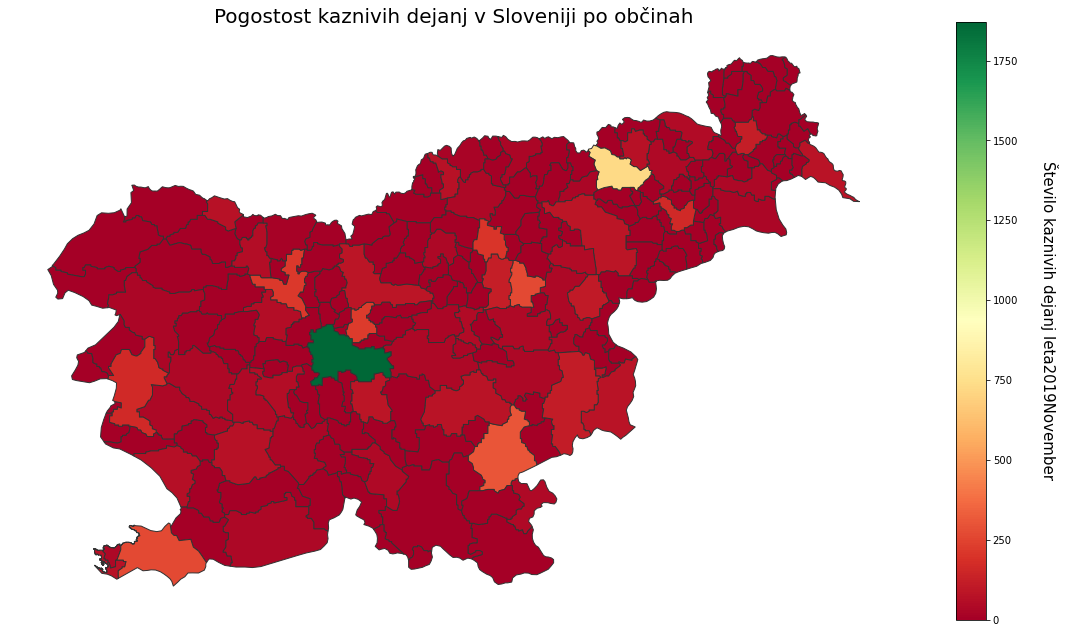

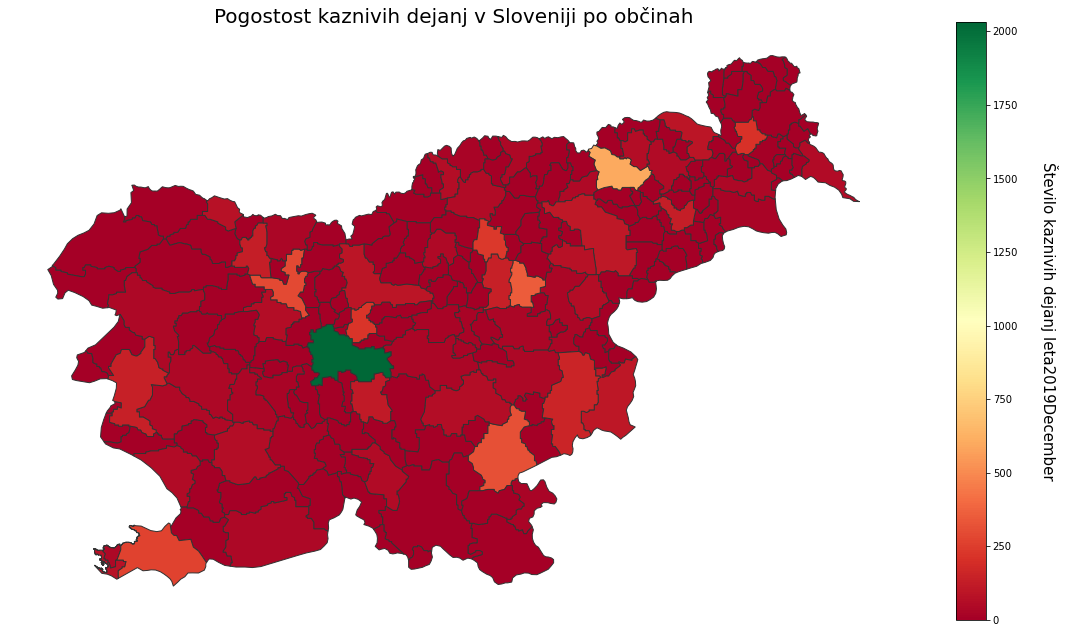

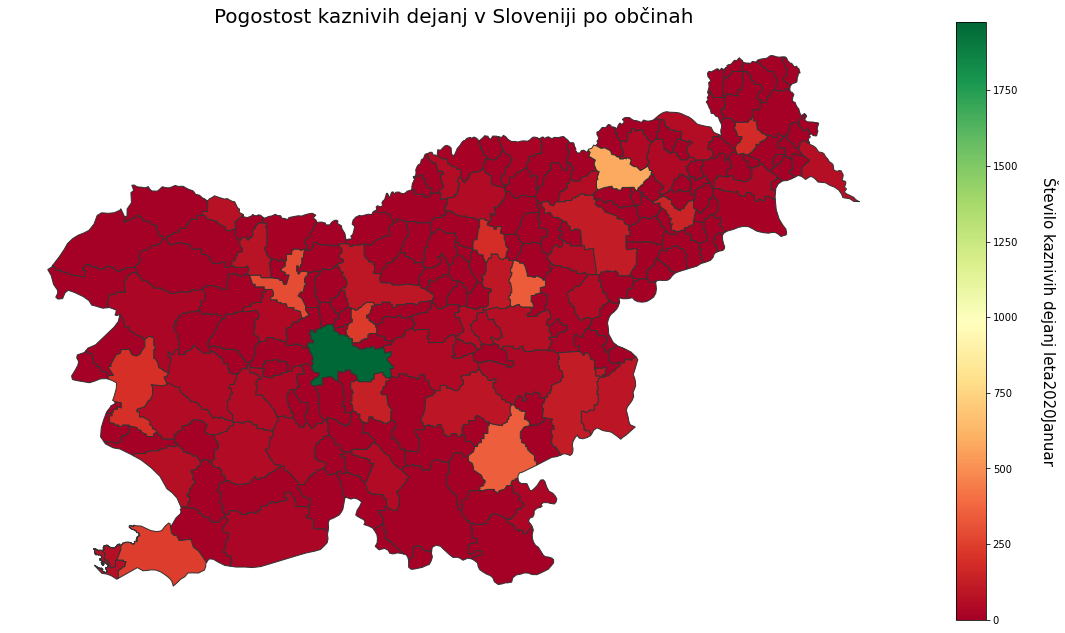

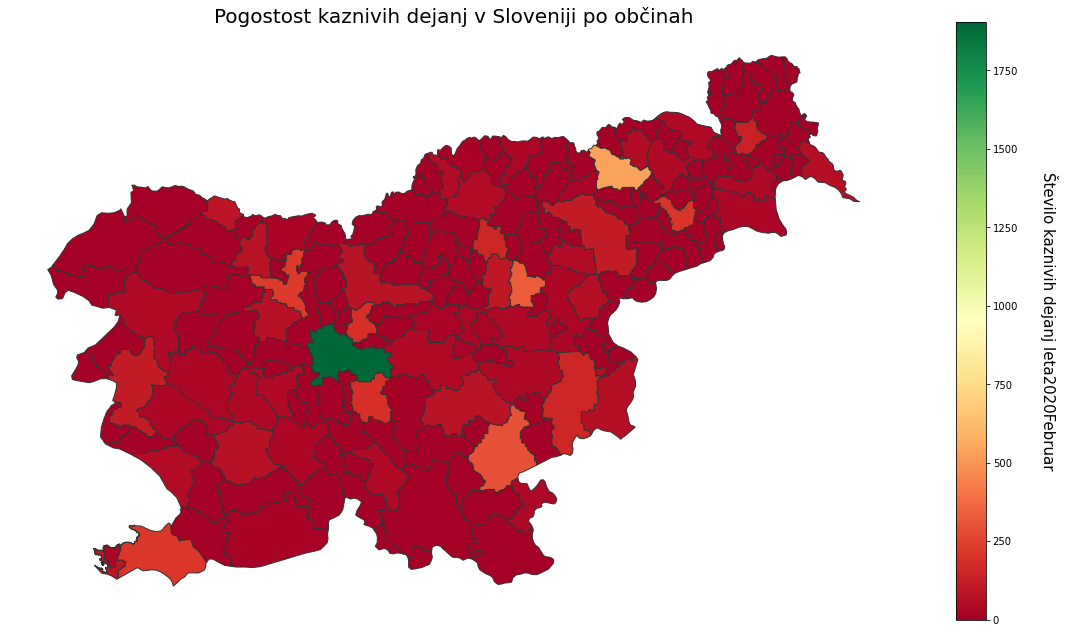

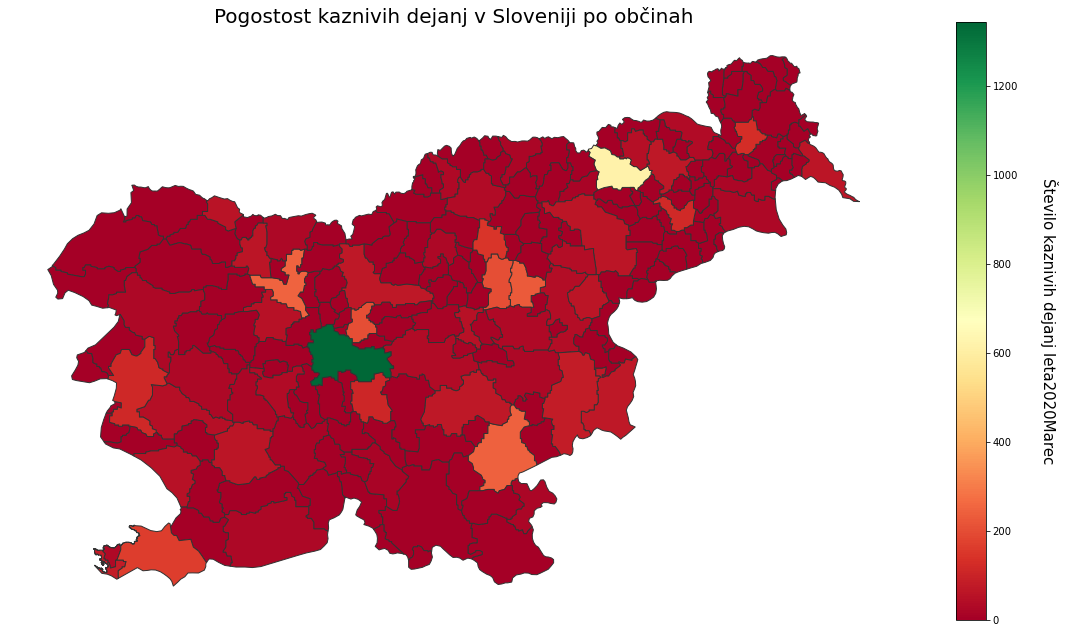

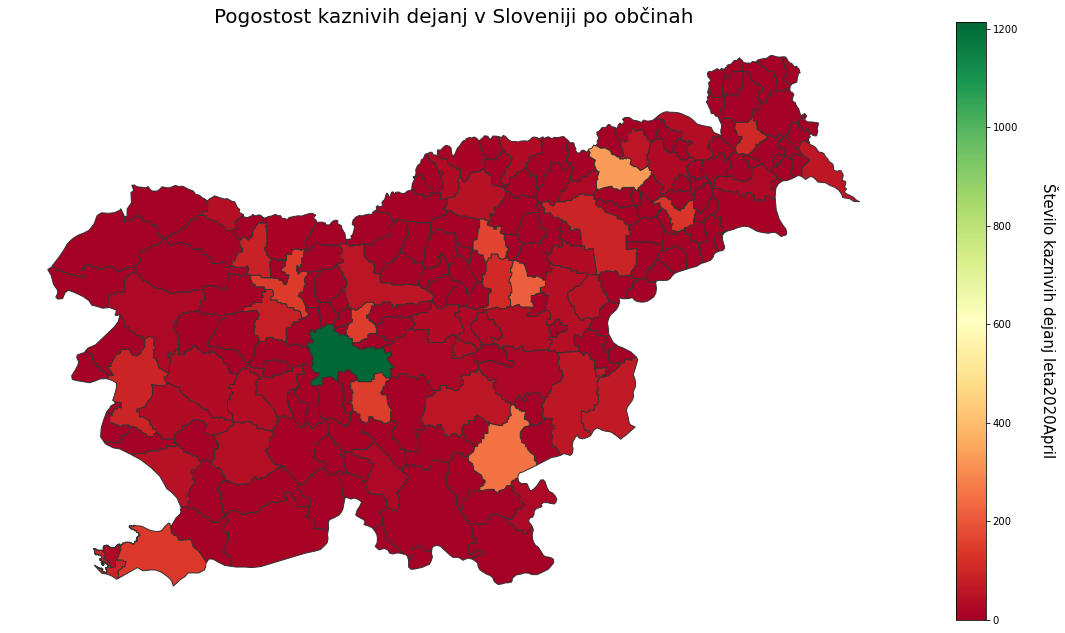

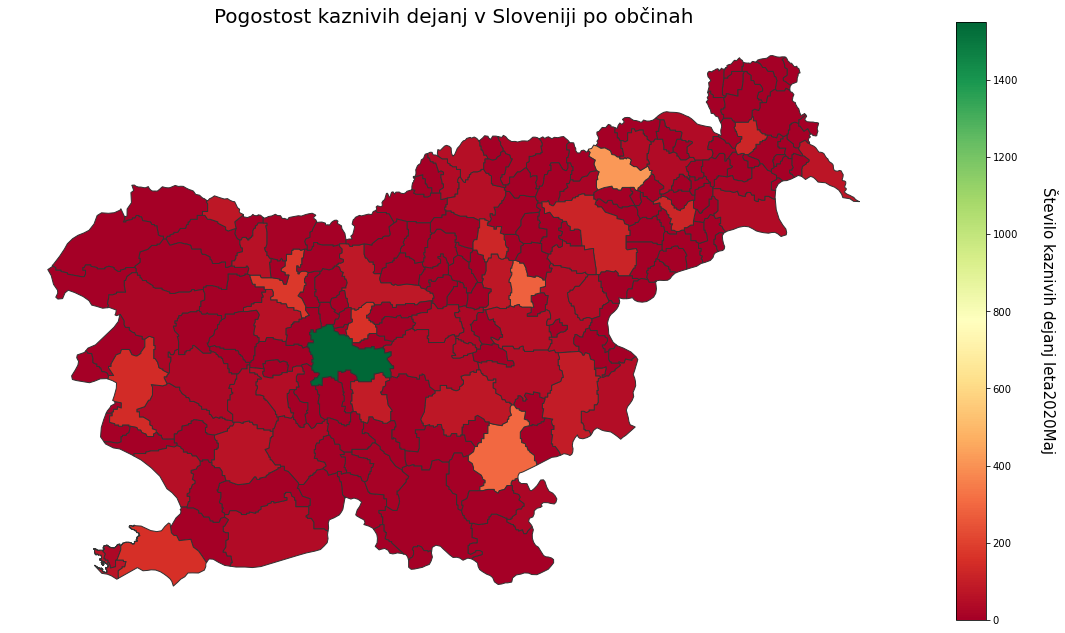

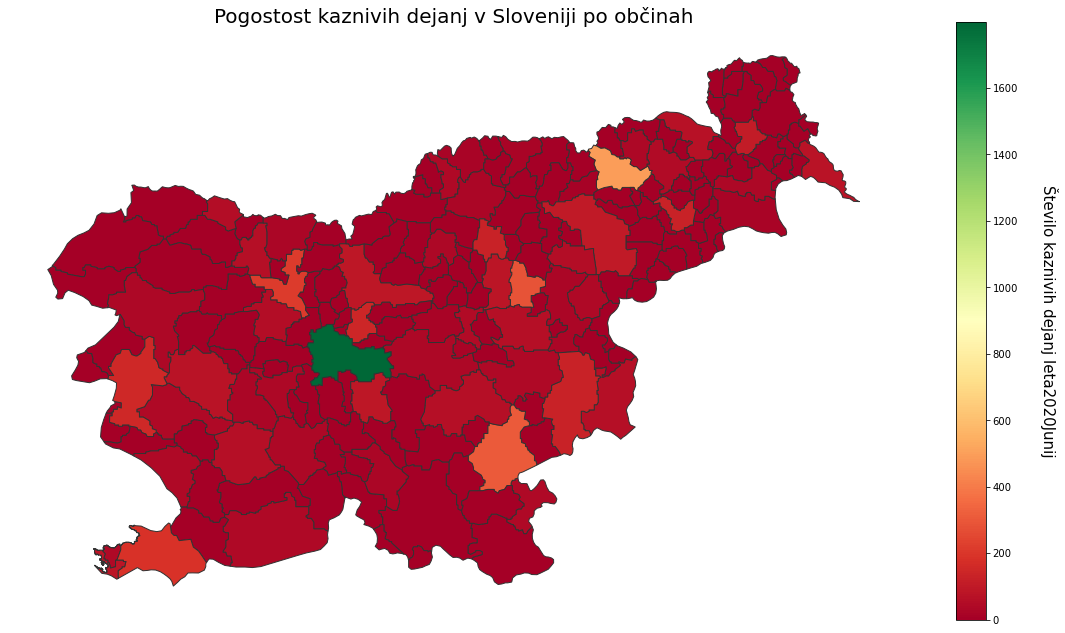

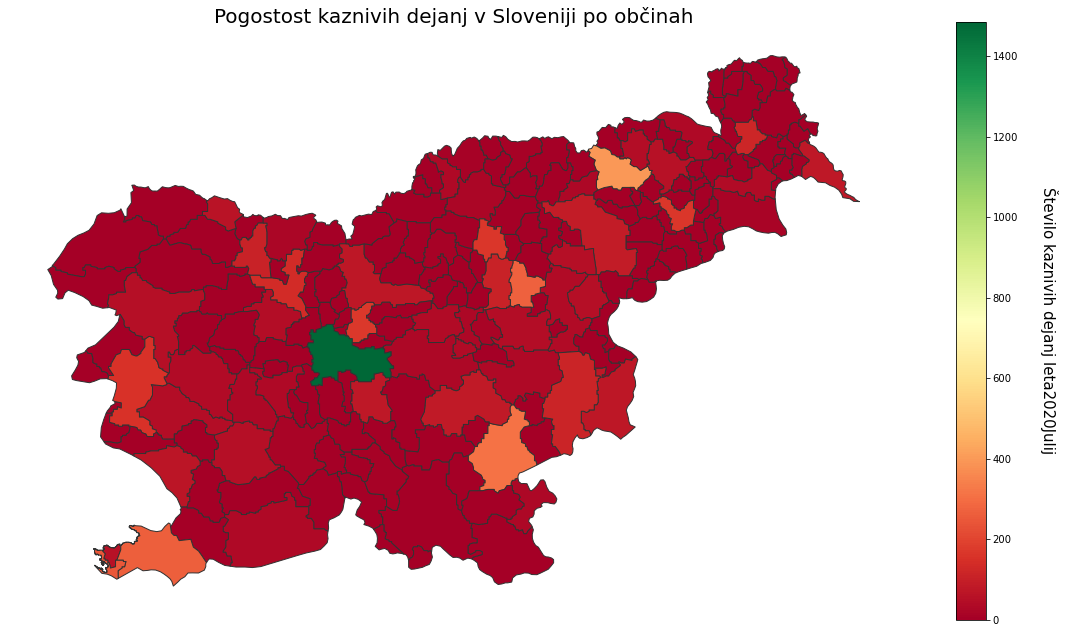

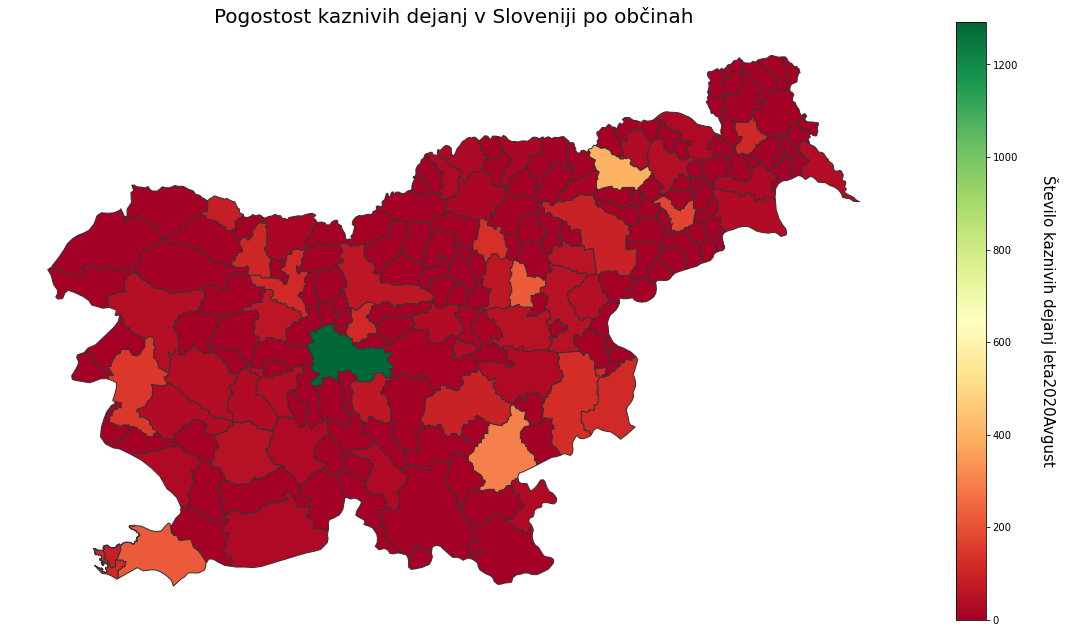

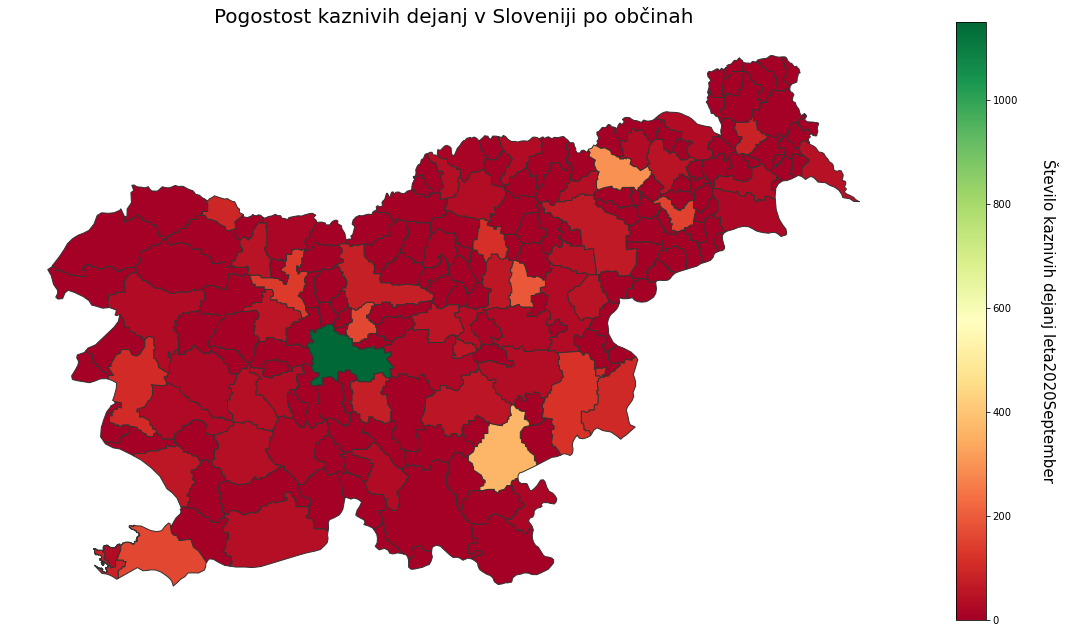

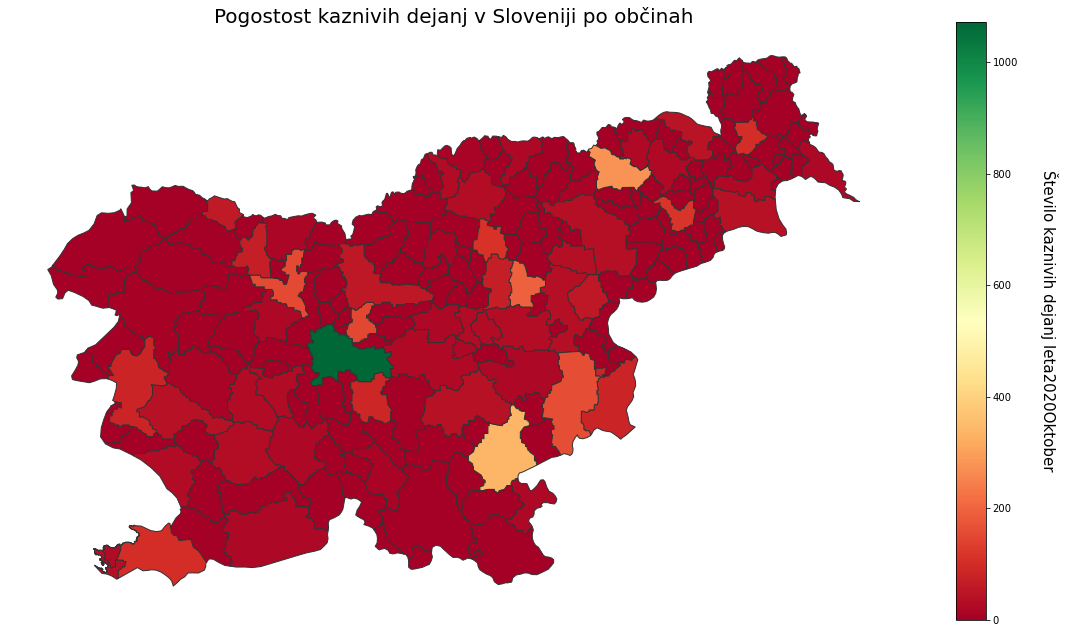

In [47]:
leto_start = 2018
leto_end = 2021
ammoutn_of_frames = (leto_end - leto_start) * 12
max_numbers = len(str(ammoutn_of_frames))
for leto in range(leto_start, leto_end):
    for mesec in mesci:
        kd_za_leto_in_mesec(leto, mesec)

In [ ]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob(path1_frames + "*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('/animation/animation1/output/lopovi.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)